# Financial News Sentiment Analysis - RoBERTa
In this notebook, we will perform sentiment analysis on financial news. The outputs will be classified as positive, negative, or neutral.

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


## Loading and Exploring the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('./data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

print("Initial dataset size:", len(df))
df.head()

Initial dataset size: 5843


,text,sentiment
0,Sentence,Sentiment
1,The GeoSolutions technology will leverage Bene...,positive
2,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
3,"For the last quarter of 2010 , Componenta 's n...",positive
4,According to the Finnish-Russian Chamber of Co...,neutral


In [4]:
# Remove duplicate entries based on text
duplicate_count = df.duplicated(subset=['text']).sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicate records")
    df = df.drop_duplicates(subset=['text'], keep='first')
    print("Dataset size after removing duplicates:", len(df))

Removing 520 duplicate records
Dataset size after removing duplicates: 5323


In [5]:
# Data cleaning and encoding: map sentiment labels directly to numeric values
def encode_sentiment(s):
    """
    Encode sentiment labels to numeric values for model training.

    Args:
        s (str): Input sentiment label

    Returns:
        int: Encoded sentiment value
            - 2: negative
            - 1: positive
            - 0: neutral
            - None: unknown values
    """
    s = str(s).lower().strip()
    if s in ['negative', 'neg', '-1']:
        return 2  # negative -> 2
    elif s in ['neutral', 'neu', '0']:
        return 0  # neutral -> 0
    elif s in ['positive', 'pos', '1']:
        return 1  # positive -> 1
    else:
        return None  # for unknown values

In [6]:
# Store the mapping for reference
sentiment_mapping = {
    'negative': 2,
    'neutral': 0,
    'positive': 1
}
print("\nSentiment Label Mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment} -> {code}")


Sentiment Label Mapping:
negative -> 2
neutral -> 0
positive -> 1


## 2. Data Preparation for RoBERTa

We will use the previously prepared data for the RoBERTa model. The train-test split has already been performed.

In [7]:
# Load fresh data for BERT (without preprocessing)
# BERT will perform its own tokenization and doesn't need traditional preprocessing
df_bert = pd.read_csv('./data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

# Remove duplicates
df_bert = df_bert.drop_duplicates(subset=['text'], keep='first')

# Encode sentiment labels
df_bert['sentiment_encoded'] = df_bert['sentiment'].apply(encode_sentiment)
df_bert = df_bert.dropna(subset=['sentiment_encoded'])
df_bert['sentiment_encoded'] = df_bert['sentiment_encoded'].astype(int)

print(f"BERT dataset size: {len(df_bert)}")
print(f"Sentiment distribution:\n{df_bert['sentiment_encoded'].value_counts().sort_index()}")

# Split data for BERT
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    df_bert['text'].values,
    df_bert['sentiment_encoded'].values,
    test_size=0.2,
    random_state=9,
    stratify=df_bert['sentiment_encoded']
)

print(f"\nBERT Training set: {len(X_train_bert)} samples")
print(f"BERT Test set: {len(X_test_bert)} samples")

BERT dataset size: 5322
Sentiment distribution:
sentiment_encoded
0    2878
1    1852
2     592
Name: count, dtype: int64

BERT Training set: 4257 samples
BERT Test set: 1065 samples


## 3. RoBERTa Tokenizer and Dataset Creation

In [8]:
# Load RoBERTa tokenizer
# ROBERTA_MODEL_NAME = 'roberta-base'  # General purpose RoBERTa
# ROBERTA_MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment'  # Alternative
ROBERTA_MODEL_NAME = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'  # Financial domain

roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_NAME)
print(f"RoBERTa Tokenizer loaded: {ROBERTA_MODEL_NAME}")

RoBERTa Tokenizer loaded: mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis


In [9]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Custom Dataset class for BERT.

        Args:
            texts (array): Text data
            labels (array): Sentiment labels
            tokenizer: BERT tokenizer
            max_length (int): Maximum token length
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [10]:
# Create RoBERTa datasets using the same data as BERT
MAX_LENGTH_ROBERTA = 128

train_dataset_roberta = SentimentDataset(
    texts=X_train_bert,
    labels=y_train_bert,
    tokenizer=roberta_tokenizer,
    max_length=MAX_LENGTH_ROBERTA
)

test_dataset_roberta = SentimentDataset(
    texts=X_test_bert,
    labels=y_test_bert,
    tokenizer=roberta_tokenizer,
    max_length=MAX_LENGTH_ROBERTA
)

# Create DataLoaders
BATCH_SIZE_ROBERTA = 16

train_loader_roberta = DataLoader(
    train_dataset_roberta,
    batch_size=BATCH_SIZE_ROBERTA,
    shuffle=True
)

test_loader_roberta = DataLoader(
    test_dataset_roberta,
    batch_size=BATCH_SIZE_ROBERTA,
    shuffle=False
)

print(f"RoBERTa Training dataset size: {len(train_dataset_roberta)}")
print(f"RoBERTa Test dataset size: {len(test_dataset_roberta)}")
print(f"Training batches: {len(train_loader_roberta)}")
print(f"Test batches: {len(test_loader_roberta)}")

RoBERTa Training dataset size: 4257
RoBERTa Test dataset size: 1065
Training batches: 267
Test batches: 67


## 4. Load RoBERTa Model and Setup Training

In [11]:
NUM_CLASSES = 3  # neutral, positive, negative

# Load RoBERTa model
roberta_model = RobertaForSequenceClassification.from_pretrained(
    ROBERTA_MODEL_NAME,
    num_labels=NUM_CLASSES,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU (if available)
roberta_model = roberta_model.to(device)

print(f"RoBERTa model loaded and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in roberta_model.parameters()):,}")

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

RoBERTa model loaded and moved to cuda
Model parameters: 82,120,707


In [12]:
# Training parameters for RoBERTa
EPOCHS_ROBERTA = 10
LEARNING_RATE_ROBERTA = 2e-5

# Optimizer
optimizer_roberta = AdamW(roberta_model.parameters(), lr=LEARNING_RATE_ROBERTA, eps=1e-8)

# Learning rate scheduler
total_steps_roberta = len(train_loader_roberta) * EPOCHS_ROBERTA

scheduler_roberta = get_linear_schedule_with_warmup(
    optimizer_roberta,
    num_warmup_steps=0,
    num_training_steps=total_steps_roberta
)

# Loss function (same as BERT)
loss_fn_roberta = nn.CrossEntropyLoss().to(device)

print(f"RoBERTa Training Setup:")
print(f"Epochs: {EPOCHS_ROBERTA}")
print(f"Learning Rate: {LEARNING_RATE_ROBERTA}")
print(f"Total training steps: {total_steps_roberta}")

RoBERTa Training Setup:
Epochs: 10
Learning Rate: 2e-05
Total training steps: 2670


## 5. Train RoBERTa Model

In [14]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    """
    Train model for one epoch.

    Returns:
        float: Average training loss
        float: Training accuracy
    """
    model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Predictions
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        losses.append(loss.item())

        # Backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)


def eval_model(model, data_loader, loss_fn, device):
    """
    Model evaluation.

    Returns:
        float: Average validation loss
        float: Validation accuracy
        np.array: True labels
        np.array: Predicted labels
    """
    model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            loss = loss_fn(logits, labels)

            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return (
        np.mean(losses),
        correct_predictions.double() / len(data_loader.dataset),
        np.array(all_labels),
        np.array(all_preds)
    )

print("Training and evaluation functions are ready.")

Training and evaluation functions are ready.


In [15]:
# Training history for RoBERTa
history_roberta = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_accuracy_roberta = 0

for epoch in range(EPOCHS_ROBERTA):
    print(f'\nEpoch {epoch + 1}/{EPOCHS_ROBERTA}')
    print('-' * 50)

    # Training
    train_loss, train_acc = train_epoch(
        roberta_model,
        train_loader_roberta,
        loss_fn_roberta,
        optimizer_roberta,
        device,
        scheduler_roberta
    )

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')

    # Evaluation
    val_loss, val_acc, _, _ = eval_model(
        roberta_model,
        test_loader_roberta,
        loss_fn_roberta,
        device
    )

    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Save history
    history_roberta['train_loss'].append(train_loss)
    history_roberta['train_acc'].append(train_acc.item())
    history_roberta['val_loss'].append(val_loss)
    history_roberta['val_acc'].append(val_acc.item())

    # Save best model
    if val_acc > best_accuracy_roberta:
        best_accuracy_roberta = val_acc
        torch.save(roberta_model.state_dict(), './models/roberta_sentiment_best.pt')
        print(f'RoBERTa model saved with accuracy: {best_accuracy_roberta:.4f}')

print(f'\nRoBERTa Training completed! Best accuracy: {best_accuracy_roberta:.4f}')


Epoch 1/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:50<00:00,  5.33it/s]


Train Loss: 0.6802, Train Accuracy: 0.7646


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 16.78it/s]


Val Loss: 0.4279, Val Accuracy: 0.8103
RoBERTa model saved with accuracy: 0.8103

Epoch 2/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:51<00:00,  5.17it/s]


Train Loss: 0.3266, Train Accuracy: 0.8666


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 15.91it/s]


Val Loss: 0.4299, Val Accuracy: 0.8282
RoBERTa model saved with accuracy: 0.8282

Epoch 3/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:51<00:00,  5.23it/s]


Train Loss: 0.2394, Train Accuracy: 0.8985


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.70it/s]


Val Loss: 0.4606, Val Accuracy: 0.8451
RoBERTa model saved with accuracy: 0.8451

Epoch 4/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:50<00:00,  5.27it/s]


Train Loss: 0.1862, Train Accuracy: 0.9246


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 16.81it/s]


Val Loss: 0.4686, Val Accuracy: 0.8573
RoBERTa model saved with accuracy: 0.8573

Epoch 5/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:50<00:00,  5.26it/s]


Train Loss: 0.1376, Train Accuracy: 0.9399


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 16.76it/s]


Val Loss: 0.5572, Val Accuracy: 0.8451

Epoch 6/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:50<00:00,  5.26it/s]


Train Loss: 0.1066, Train Accuracy: 0.9561


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.03it/s]


Val Loss: 0.7462, Val Accuracy: 0.8404

Epoch 7/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:51<00:00,  5.22it/s]


Train Loss: 0.0889, Train Accuracy: 0.9683


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 16.92it/s]


Val Loss: 0.6610, Val Accuracy: 0.8610
RoBERTa model saved with accuracy: 0.8610

Epoch 8/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:50<00:00,  5.30it/s]


Train Loss: 0.0705, Train Accuracy: 0.9742


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 17.16it/s]


Val Loss: 0.7220, Val Accuracy: 0.8610

Epoch 9/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:50<00:00,  5.29it/s]


Train Loss: 0.0571, Train Accuracy: 0.9800


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 17.16it/s]


Val Loss: 0.7834, Val Accuracy: 0.8545

Epoch 10/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [00:50<00:00,  5.28it/s]


Train Loss: 0.0488, Train Accuracy: 0.9836


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 17.04it/s]


Val Loss: 0.7851, Val Accuracy: 0.8620
RoBERTa model saved with accuracy: 0.8620

RoBERTa Training completed! Best accuracy: 0.8620


## 6. RoBERTa Training History Visualization

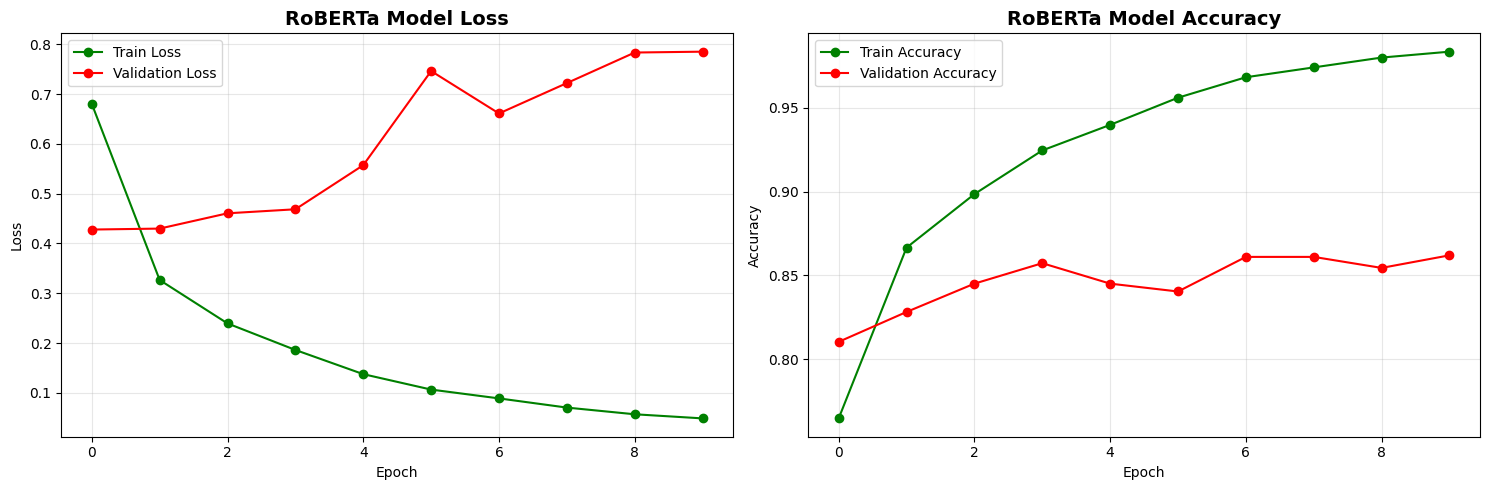

In [16]:
# Plot RoBERTa training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history_roberta['train_loss'], label='Train Loss', marker='o', color='green')
ax1.plot(history_roberta['val_loss'], label='Validation Loss', marker='o', color='red')
ax1.set_title('RoBERTa Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history_roberta['train_acc'], label='Train Accuracy', marker='o', color='green')
ax2.plot(history_roberta['val_acc'], label='Validation Accuracy', marker='o', color='red')
ax2.set_title('RoBERTa Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. RoBERTa Test Set Evaluation

In [18]:
# Load the best RoBERTa model
roberta_model.load_state_dict(torch.load('./models/roberta_sentiment_best.pt'))
print("Best RoBERTa model loaded.")

# Evaluation on test set
test_loss_roberta, test_acc_roberta, y_true_roberta, y_pred_roberta = eval_model(
    roberta_model,
    test_loader_roberta,
    loss_fn_roberta,
    device
)

print(f"\nRoBERTa Model Test Results:")
print(f"Test Loss: {test_loss_roberta:.4f}")
print(f"Test Accuracy: {test_acc_roberta:.4f}")
print(f"Test F1-Score (weighted): {f1_score(y_true_roberta, y_pred_roberta, average='weighted'):.4f}")

Best RoBERTa model loaded.


Evaluating: 100%|██████████| 67/67 [00:03<00:00, 17.04it/s]


RoBERTa Model Test Results:
Test Loss: 0.7851
Test Accuracy: 0.8620
Test F1-Score (weighted): 0.8630


In [19]:
# Classification Report
sentiment_labels = ['neutral', 'positive', 'negative']
print("\nRoBERTa Classification Report:")
print(classification_report(y_true_roberta, y_pred_roberta, target_names=sentiment_labels))


RoBERTa Classification Report:
              precision    recall  f1-score   support

     neutral       0.91      0.89      0.90       576
    positive       0.86      0.88      0.87       371
    negative       0.64      0.69      0.66       118

    accuracy                           0.86      1065
   macro avg       0.81      0.82      0.81      1065
weighted avg       0.86      0.86      0.86      1065



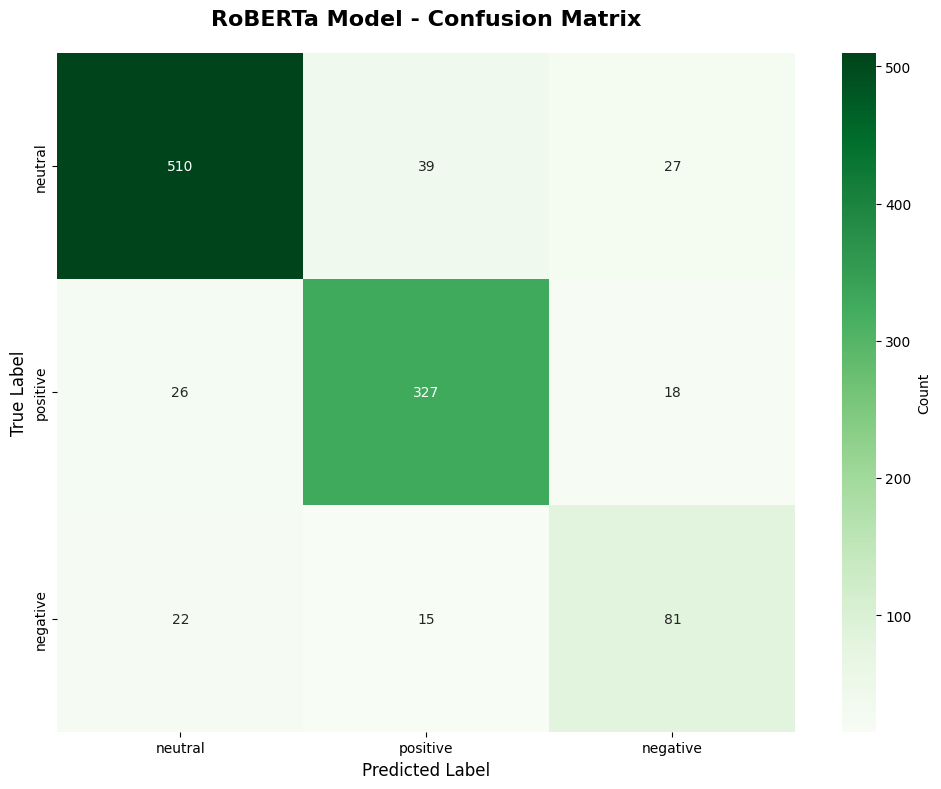


Accuracy for each class:
neutral: 0.8854
positive: 0.8814
negative: 0.6864


In [20]:
# RoBERTa Confusion Matrix
cm_roberta = confusion_matrix(y_true_roberta, y_pred_roberta)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_roberta,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=sentiment_labels,
    yticklabels=sentiment_labels,
    cbar_kws={'label': 'Count'}
)
plt.title('RoBERTa Model - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate accuracy for each class
print("\nAccuracy for each class:")
for i, label in enumerate(sentiment_labels):
    class_accuracy = cm_roberta[i, i] / cm_roberta[i].sum()
    print(f"{label}: {class_accuracy:.4f}")

## 8. RoBERTa Prediction Function and Test Examples

In [21]:
# RoBERTa prediction function (similar to BERT)
def predict_sentiment_roberta(text, model, tokenizer, device, max_length=128):
    """
    Predict sentiment using RoBERTa model.

    Args:
        text (str): Text to predict
        model: Trained RoBERTa model
        tokenizer: RoBERTa tokenizer
        device: CPU or GPU
        max_length (int): Maximum token length

    Returns:
        dict: Prediction result and probabilities
    """
    model.eval()

    # Tokenize the text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    sentiment_labels_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
    predicted_sentiment = sentiment_labels_map[prediction.item()]

    probs = probabilities[0].cpu().numpy()

    return {
        'sentiment': predicted_sentiment,
        'confidence': probs[prediction.item()],
        'probabilities': {
            'neutral': probs[0],
            'positive': probs[1],
            'negative': probs[2]
        }
    }

print("RoBERTa prediction function is ready.")

RoBERTa prediction function is ready.


In [23]:
# Test texts
test_texts_roberta = [
    "Stock market reaches all-time high as tech sector booms",
    "Company announces massive layoffs amid financial troubles",
    "Market remains stable as Fed maintains current interest rates",
    "The company's earnings report exceeded expectations.",
    "Investors are concerned about the declining profit margins",
    "The merger is expected to create significant value for shareholders"
]

# Test RoBERTa with same examples
print("\n" + "="*80)
print("RoBERTa MODEL SENTIMENT PREDICTIONS")
print("="*80)

for i, text in enumerate(test_texts_roberta, 1):
    result = predict_sentiment_roberta(text, roberta_model, roberta_tokenizer, device)

    print(f"\n{i}. Text: {text}")
    print(f"   Predicted Sentiment: {result['sentiment'].upper()}")
    print(f"   Confidence: {result['confidence']:.4f}")
    print(f"   Probabilities:")
    for sentiment, prob in result['probabilities'].items():
        print(f"      {sentiment}: {prob:.4f}")
    print("-" * 80)


RoBERTa MODEL SENTIMENT PREDICTIONS

1. Text: Stock market reaches all-time high as tech sector booms
   Predicted Sentiment: POSITIVE
   Confidence: 0.9997
   Probabilities:
      neutral: 0.0000
      positive: 0.9997
      negative: 0.0003
--------------------------------------------------------------------------------

2. Text: Company announces massive layoffs amid financial troubles
   Predicted Sentiment: NEGATIVE
   Confidence: 0.9996
   Probabilities:
      neutral: 0.0001
      positive: 0.0002
      negative: 0.9996
--------------------------------------------------------------------------------

3. Text: Market remains stable as Fed maintains current interest rates
   Predicted Sentiment: POSITIVE
   Confidence: 0.9683
   Probabilities:
      neutral: 0.0316
      positive: 0.9683
      negative: 0.0001
--------------------------------------------------------------------------------

4. Text: The company's earnings report exceeded expectations.
   Predicted Sentiment: POSI

## 9. Save RoBERTa Model

In [24]:
# Save RoBERTa model and tokenizer
roberta_model_save_path = './models/roberta_model'
os.makedirs(roberta_model_save_path, exist_ok=True)

# Save the model
roberta_model.save_pretrained(roberta_model_save_path)
# Save the tokenizer
roberta_tokenizer.save_pretrained(roberta_model_save_path)

print(f"\nRoBERTa model and tokenizer saved: {roberta_model_save_path}")
print("\nSaved files:")
for file in os.listdir(roberta_model_save_path):
    print(f"  - {file}")


RoBERTa model and tokenizer saved: ./models/roberta_model

Saved files:
  - tokenizer_config.json
  - config.json
  - vocab.json
  - model.safetensors
  - merges.txt
  - special_tokens_map.json


In [25]:
import os

file_path = '/content/models/roberta_sentiment_best.pt'

if os.path.exists(file_path):
    file_size_bytes = os.path.getsize(file_path)
    file_size_mb = file_size_bytes / (1024 * 1024) # Convert bytes to MB
    print(f"File size of '{file_path}': {file_size_bytes} bytes ({file_size_mb:.2f} MB)")
else:
    print(f"File '{file_path}' does not exist.")

File size of '/content/models/roberta_sentiment_best.pt': 328528174 bytes (313.31 MB)


In [26]:
import os

file_path = '/content/models/roberta_model/model.safetensors'

if os.path.exists(file_path):
    file_size_bytes = os.path.getsize(file_path)
    file_size_mb = file_size_bytes / (1024 * 1024) # Convert bytes to MB
    print(f"File size of '{file_path}': {file_size_bytes} bytes ({file_size_mb:.2f} MB)")
else:
    print(f"File '{file_path}' does not exist.")

File size of '/content/models/roberta_model/model.safetensors': 328495356 bytes (313.28 MB)


In [29]:
from google.colab import files
import os

file_to_download = '/content/models/roberta_sentiment_best.pt'

if os.path.exists(file_to_download):
    files.download(file_to_download)
    print(f"'{file_to_download}' downloaded successfully.")
else:
    print(f"File '{file_to_download}' does not exist. Please check the path.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'/content/models/roberta_sentiment_best.pt' downloaded successfully.


In [30]:
from google.colab import files
import os

file_to_download = '/content/models/roberta_model/model.safetensors'

if os.path.exists(file_to_download):
    files.download(file_to_download)
    print(f"'{file_to_download}' downloaded successfully.")
else:
    print(f"File '{file_to_download}' does not exist. Please check the path.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'/content/models/roberta_model/model.safetensors' downloaded successfully.
